Application of GNN for calculating the solubility of Molecule (Graph Level Prediction)

https://medium.com/@tejpal.abhyuday/application-of-gnn-for-calculating-the-solubility-of-molecule-graph-level-prediction-8bac5fabf600

In [4]:
# Install PyTorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

# Install PyTorch Geometric
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:00


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 8.4 MB/s eta 0:00:00


In [ ]:
import torch
import rdkit
from torch_geometric.datasets import MoleculeNet

In [7]:
# Load the ESOL dataset
dataset = MoleculeNet(root=".", name="ESOL")

# Extract SMILES and target values from the dataset
SMILES_list = [data.smiles for data in dataset]
y_list = [data.y.tolist() for data in dataset]  # Convert tensor to list for better readability

# Print the first few entries to verify
print("SMILES_list:", SMILES_list[:10])
print("y_list:", y_list[:10])

SMILES_list: ['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', 'Cc1occc1C(=O)Nc2ccccc2', 'CC(C)=CCCC(C)=CC(=O)', 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43', 'c1ccsc1', 'c2ccc1scnc1c2 ', 'Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl', 'CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O', 'ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl', 'COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C ']
y_list: [[[-0.7699999809265137]], [[-3.299999952316284]], [[-2.059999942779541]], [[-7.869999885559082]], [[-1.3300000429153442]], [[-1.5]], [[-7.320000171661377]], [[-5.03000020980835]], [[-6.289999961853027]], [[-4.420000076293945]]]


#Visualize a molecule

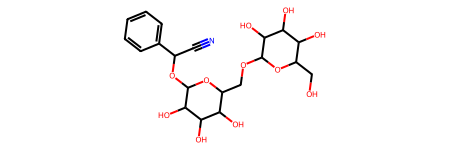

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

# Defining the GNN

Import functions to run the code

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, CGConv, DynamicEdgeConv, GCNConv
from torch_geometric.utils import add_self_loops
from sklearn.model_selection import train_test_split
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdMolHash
from rdkit import DataStructs
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem import Draw

In [9]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden
model = GCN()

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


Print structure of the GNN model

In [ ]:
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Root mean squared error

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

Use GPU for training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Wrap data in a data loader

In [ ]:
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

Train the model

In [10]:
def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665947914123535
Epoch 100 | Train Loss 0.8504207730293274
Epoch 200 | Train Loss 1.1154390573501587
Epoch 300 | Train Loss 0.32911959290504456
Epoch 400 | Train Loss 0.23744039237499237
Epoch 500 | Train Loss 0.38848552107810974
Epoch 600 | Train Loss 0.22591347992420197
Epoch 700 | Train Loss 0.06603380292654037
Epoch 800 | Train Loss 0.161929190158844
Epoch 900 | Train Loss 0.1568988561630249
Epoch 1000 | Train Loss 0.046887725591659546
Epoch 1100 | Train Loss 0.03903582692146301
Epoch 1200 | Train Loss 0.15991733968257904
Epoch 1300 | Train Loss 0.08483908325433731
Epoch 1400 | Train Loss 0.04848349094390869
Epoch 1500 | Train Loss 0.018160203471779823
Epoch 1600 | Train Loss 0.02361152321100235
Epoch 1700 | Train Loss 0.02528112567961216
Epoch 1800 | Train Loss 0.04550778865814209
Epoch 1900 | Train Loss 0.05733415484428406


Visualize learning (training loss)

<AxesSubplot:>

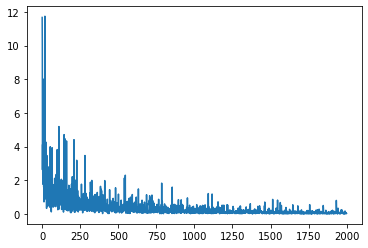

In [ ]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(loss_indices, losses_float)
plt

Analyze the results for one batch

In [ ]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,0.940,0.461395
1,-6.237,-3.025320
2,-2.540,-2.708921
3,-5.680,-5.809837
4,-2.460,-1.651546
...,...,...
59,-1.890,-1.544902
60,-2.218,-3.999350
61,-3.583,-1.239443
62,-2.580,-2.514384


Plot the predictions

<AxesSubplot:xlabel='y_real', ylabel='y_pred'>

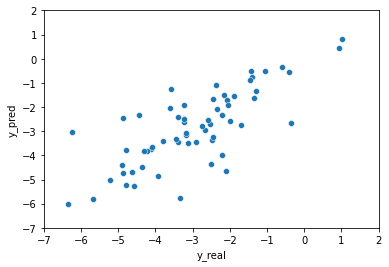

In [ ]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [ ]:
y_true=list(df["y_real"])
y_pred=list(df["y_pred"])

Calculate RMSE

In [ ]:
# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Calculate RMSE
rmse = calculate_rmse(np.array(y_true), np.array(y_pred))

# Print RMSE
print(f"RMSE: {rmse}")

RMSE: 1.0470363272377388


# We recommend tuned hyperparameters

Changed parameters of the exist model:

- GATConv

- one additional layer

- optimizer torch.optim.RMSprop

- learning rate

- hidden channels

- remove pooling

- change epochs

For your convenience copy code and change

In [ ]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

import numpy as np

y_true=list(df["y_real"])
y_pred=list(df["y_pred"])

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Calculate RMSE
rmse = calculate_rmse(np.array(y_true), np.array(y_pred))

# Print RMSE
print(f"RMSE: {rmse}")

# Features (rdkit tool)

Change features (9 local features are avalible in rdkit and 5 features are added as global features to each chemical element (same as atomic features))

#Input data

#Features

Note. We estimated all features provided by rdkit, we recommended to select as features only stable ones (fo this we run code 5 times and estimated if they are still without any changes for the same SMILES)

Define a function to calculate the distance between two points in 3D space

In [ ]:
def calculate_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2 + (coord1[2] - coord2[2])**2)

Define a function to extract features based on distances from the center

In [ ]:
def extract_features(molecule):
    mol = Chem.MolFromSmiles(molecule)  # Convert SMILES to an RDKit molecule object
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    center = np.array([0.0, 0.0, 0.0])  # Define the center of the molecule
    features = []
    for atom in mol.GetAtoms():
        coord = mol.GetConformer().GetAtomPosition(atom.GetIdx())
        distance = calculate_distance(coord, center)
        features.append(distance)
    return features

Initialize an empty list to store features for each molecule

In [ ]:
features_list = []

# Iterate through each SMILES string
for smiles in SMILES_list:
    # Convert SMILES to an RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)

    # Initialize an empty list to store features for each atom
    atom_features_list = []

    # Iterate through each atom in the molecule
    for atom in mol.GetAtoms():
        # Define local features:
        features_lst = [

            int(atom.GetAtomicNum()),  # Atomic number
            int(atom.GetTotalNumHs()),  # Number of hydrogen atoms
            int(atom.GetTotalValence()),  # Number of valence electrons
            int(atom.GetNumRadicalElectrons()),  # Number of radical electrons
            int(atom.GetFormalCharge()),  # Formal charge
            int(atom.GetHybridization()),  # change format for removing: rdkit.Chem.rdchem.HybridizationType.SP in desciptions.
            #Note: For sp1 is marked as rdkit.Chem.rdchem.HybridizationType.SP (without any number).

            #new features from SMILES
            int((atom.GetMass()- 10.812)/116.092),  # Number of valence electrons
            int((atom.GetAtomicNum() - 1.5)/0.6),
            int((atom.GetAtomicNum()- 0.64)/0.76)
        ]

        # Additional global features
        min_degree = atom.GetDegree()
        num_hbond_donors = 1 if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() > 0 else 0
        num_rings = 1 if atom.IsInRing() else 0
        num_rotatable_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
        polar_surface_area = rdMolDescriptors.CalcTPSA(mol)  # Calculate polar surface area

        # Append additional features to the atom's features
        features_lst += [min_degree, num_hbond_donors, num_rings, num_rotatable_bonds, int(polar_surface_area)]

        # Append the atom's features to the list
        atom_features_list.append(features_lst)

    # Append the features for each atom to the list
    features_list.append(atom_features_list)
x=features_list
#print(x)

#Edge indexes

In [ ]:
# Initialize list to store all edge indexes
edge_index = []

# Iterate through each SMILES string
for smiles in SMILES_list:
    # Convert SMILES string to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)

    # Get atom and bond information
    atoms = mol.GetAtoms()
    bonds = mol.GetBonds()

    # Initialize edge indexes list for this SMILES
    edge_indexes = []

    # Iterate through bonds to get the edge indexes
    for bond in bonds:
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        edge_indexes.append([begin_idx, end_idx])
        edge_indexes.append([end_idx, begin_idx])  # Add the reverse direction as well

    # Append the edge indexes for this SMILES to the overall list
    edge_index.append(edge_indexes)

#Input data for the GNN model

In [ ]:
data = []

for i in range(len(x)):
    x_graph = torch.tensor(x[i], dtype=torch.float32)
    edge_index_graph = torch.tensor(edge_index[i], dtype=torch.long).t().contiguous()
    y_graph = torch.tensor(y[i], dtype=torch.float32)

    data_graph = Data(x=x_graph, edge_index=edge_index_graph, y=y_graph)
    data.append(data_graph)

# Code (ESOL library) with modifyed features

GCN(
  (initial_conv): GCNConv(14, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13569
Starting training...
Epoch 0 | Train Loss 11.45377254486084
Epoch 100 | Train Loss 0.6381416916847229
Epoch 200 | Train Loss 0.453571081161499
Epoch 300 | Train Loss 0.6672500967979431
Epoch 400 | Train Loss 0.3373631238937378
Epoch 500 | Train Loss 0.3855559527873993
Epoch 600 | Train Loss 0.501336932182312
Epoch 700 | Train Loss 0.22447647154331207
Epoch 800 | Train Loss 0.20879600942134857
Epoch 900 | Train Loss 0.15577635169029236
Epoch 1000 | Train Loss 0.05079905688762665
Epoch 1100 | Train Loss 0.04300976172089577
Epoch 1200 | Train Loss 0.08220664411783218
Epoch 1300 | Train Loss 0.1867268830537796
Epoch 1400 | Train Loss 0.0742432102560997
Epoch 1500 | Train Loss 0.026662612333893776
Epoch 1600 | Train Loss 0.01951376162469387
Epoch 1700 | Train Loss 0.07720822840929031

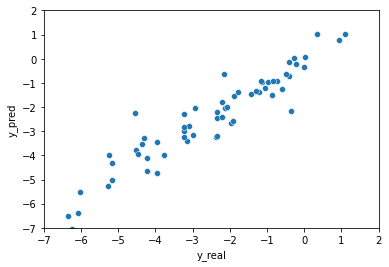

In [ ]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(len(x[0][0]), embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

import pandas as pd

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

import numpy as np

y_true=list(df["y_real"])
y_pred=list(df["y_pred"])

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Calculate RMSE
rmse = calculate_rmse(np.array(y_true), np.array(y_pred))

# Print RMSE
print(f"RMSE: {rmse}")